In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

In [2]:
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [3]:
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from tensorflow.keras import Model, Sequential, layers
from keras.layers import Dense, Conv1D, Flatten, BatchNormalization, Activation, Dropout
from keras.optimizers import SGD
from keras import optimizers, regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger

In [ ]:
# import optuna

### Synthetic spectra generator

In [4]:
max_features = 15
n_points = 640
nu = np.linspace(0, 1, n_points)

def random_chi3():
    """
    generates a random spectrum, without NRB. 
    output:
        params =  matrix of parameters. 
                  each row corresponds to the [amplitude, resonance, linewidth] of each generated feature (n_lor, 3).
    """
    n_lor = np.random.randint(1, max_features)
    a = np.random.uniform(0, 1, n_lor)
    w = np.random.uniform(0, 1, n_lor)
    g = np.random.uniform(0.001, 0.008, n_lor)
    params = np.c_[a, w, g]
    return params

def build_chi3(params):
    """
    buiilds the normalized chi3 complex vector.
    inputs: 
        params: (n_lor, 3)
    outputs:
        chi3: complex, (n_points, )
    """
    chi3 = np.sum(params[:,0]/(-nu[:,np.newaxis]+params[:,1]-1j*params[:,2]), axis=1)
    return chi3/np.max(np.abs(chi3))

def sigmoid(x, c, b):
    return 1/(1+np.exp(-(x-c)*b))

def generate_nrb():
    """
    produces a normalized shape for the NRB.
    outputs:
        NRB: (n_points, )
    """
    bs = np.random.normal(10, 5, 2)
    c1 = np.random.normal(0.2, 0.3)
    c2 = np.random.normal(0.7, 0.3)
    cs = np.r_[c1, c2]
    sig1 = sigmoid(nu, cs[0], bs[0])
    sig2 = sigmoid(nu, cs[1], -bs[1])
    nrb  = sig1*sig2
    return nrb

def get_spectrum():
    """
    produces a cars spectrum.
    it outputs the normalized cars and the corresponding imaginary part.
    outputs:
        cars: (n_points, )
        chi3.imag: (n_points, )
    """
    chi3 = build_chi3(random_chi3()) * np.random.uniform(0.3, 1)
    nrb = generate_nrb()
    noise = np.random.randn(n_points) * np.random.uniform(0.0005, 0.003)
    cars = ((np.abs(chi3+nrb)**2)/2+noise)
    return cars, chi3.imag

def generate_batch(size=10000):
    X = np.empty((size, n_points, 1))
    y = np.empty((size, n_points))
    
    for i in range(size):
        X[i,:,0], y[i,:] = get_spectrum()
    return X, y

def synthetic_CARS_Raman():
    # cars, imag, chi3, nrb, noise = get_spectrum()
    cars, imag = get_spectrum()

    plt.figure(figsize=(16, 8))
    plt.plot(nu, cars, 'b', label='CARS', linewidth=1)
    plt.plot(nu, imag, 'r', label='Raman', linewidth=1)
    # plt.plot(nu,chi3,'k',label='chi3')
    # plt.plot(nu,nrb,'y',label='NRB',linewidth=10)
    # plt.plot(nu,noise,'y',label='noise')
    plt.xlabel("Wavenumbers (1/cm)", fontsize=15)
    plt.xticks(fontsize=13)
    plt.ylabel("Intencity [A. U.]", fontsize=15)
    plt.yticks(fontsize=13)
    # plt.legend(fontsize=13)
    plt.legend()
    plt.show()

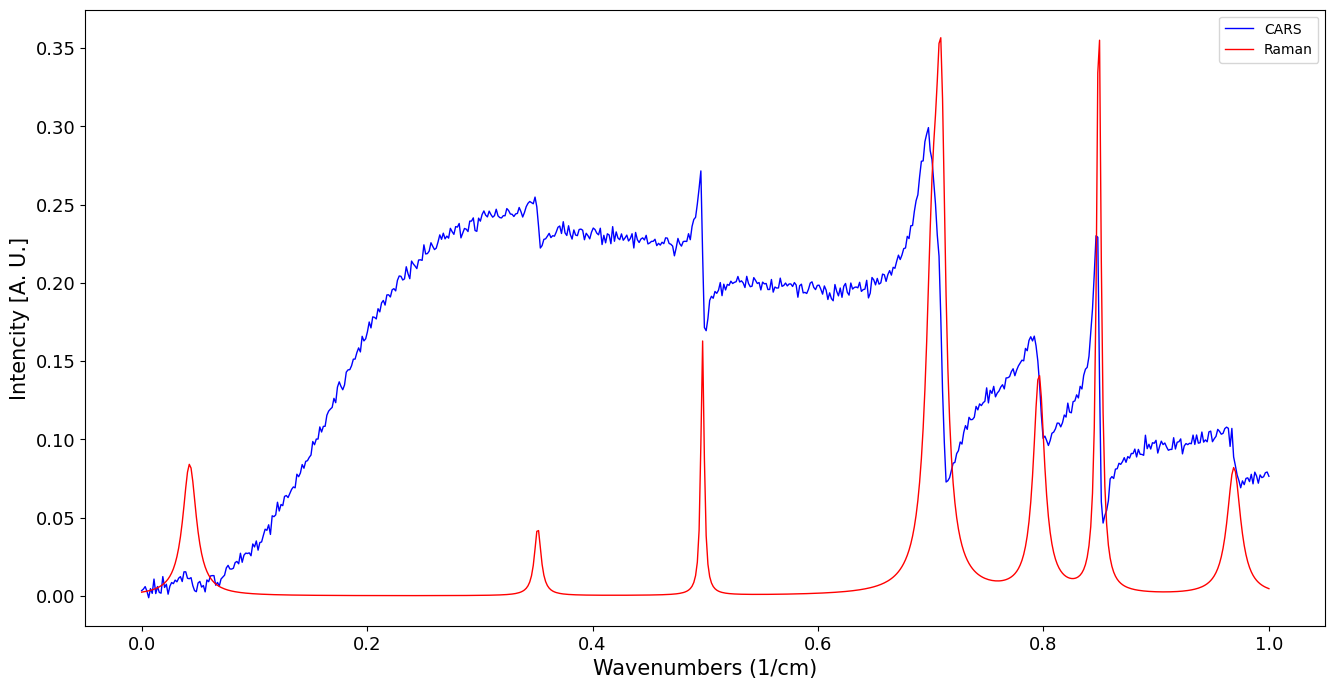

In [5]:
synthetic_CARS_Raman()

### Check if GPU available!

In [ ]:
# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

### SpecNet

In [6]:
tf.keras.backend.clear_session()
SpecNet = Sequential()
SpecNet.add(BatchNormalization(axis=-1, 
                               momentum=0.99, epsilon=0.001, 
                               center=True, scale=True, 
                               beta_initializer='zeros', gamma_initializer='ones', 
                               moving_mean_initializer='zeros', moving_variance_initializer='ones', 
                               beta_regularizer=None, gamma_regularizer=None, 
                               beta_constraint=None, gamma_constraint=None, 
                               input_shape=(n_points,1)))
SpecNet.add(Activation('relu'))
SpecNet.add(Conv1D(128, activation='relu', kernel_size=(32)))
SpecNet.add(Conv1D(64, activation='relu', kernel_size=(16)))
SpecNet.add(Conv1D(16, activation='relu', kernel_size=(8)))
SpecNet.add(Conv1D(16, activation='relu', kernel_size=(8)))
SpecNet.add(Conv1D(16, activation='relu', kernel_size=(8)))
SpecNet.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0,l2=0.1)))
SpecNet.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0,l2=0.1)))
SpecNet.add(Flatten())
SpecNet.add(Dropout(.25))
SpecNet.add(Dense(n_points, activation='relu'))
SpecNet.compile(loss='mse', 
                optimizer='Adam', 
                metrics=['mean_absolute_error', 'mse', 'accuracy'])
SpecNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 640, 1)           4         
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 640, 1)            0         
                                                                 
 conv1d (Conv1D)             (None, 609, 128)          4224      
                                                                 
 conv1d_1 (Conv1D)           (None, 594, 64)           131136    
                                                                 
 conv1d_2 (Conv1D)           (None, 587, 16)           8208      
                                                                 
 conv1d_3 (Conv1D)           (None, 580, 16)           2064      
                                                        

### Optimizing the model

Define the `objective function` that will be optimized by Optuna. This function takes the `trial object` as an argument and returns the `evaluation metric` you want to maximize or minimize. In this case, we'll maximize the validation accuracy!

In [ ]:
def create_model_opt(trial):
    tf.keras.backend.clear_session()
    model_opt = Sequential()
    model_opt.add(BatchNormalization(axis=-1, 
                                     momentum=0.99, epsilon=0.001, 
                                     center=True, scale=True, 
                                     beta_initializer='zeros', gamma_initializer='ones', 
                                     moving_mean_initializer='zeros', moving_variance_initializer='ones', 
                                     beta_regularizer=None, gamma_regularizer=None, 
                                     beta_constraint=None, gamma_constraint=None, 
                                     input_shape=(n_points,1)))
    model_opt.add(Activation('relu'))
    model_opt.add(Conv1D(128, activation='relu', kernel_size=(32), padding='same'))
    model_opt.add(Conv1D(64, activation='relu', kernel_size=(16), padding='same'))
    model_opt.add(Conv1D(16, activation='relu', kernel_size=(8), padding='same'))
    model_opt.add(Conv1D(16, activation='relu', kernel_size=(8), padding='same'))
    model_opt.add(Conv1D(16, activation='relu', kernel_size=(8), padding='same'))
    model_opt.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0,l2=0.1)))
    model_opt.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0,l2=0.1)))
    model_opt.add(layers.Flatten())
    # optimizing the dropout rate
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.00,0.25,0.50,0.75])
    model_opt.add(layers.Dropout(dropout_rate))
    model_opt.add(layers.Dense(640, activation='relu'))
    # optimizing the learning rate of the Adam optimizer
    learning_rate = trial.suggest_categorical('learning_rate', [0.001,0.0001,0.00001])
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    model_opt.compile(loss='mse',
                      optimizer=optimizer,  
                      metrics=['mean_absolute_error', 'mse', 'accuracy'])
    return model_opt


def objective(trial):
    model_opt = create_model_opt(trial)
    # optimizing the batch_size
    batch_sizes = trial.suggest_categorical('batch_sizes', [32,256,1024])
    history = model_opt.fit(X_train, y_train, 
                            #validation_split=0.25,
                            validation_data=(X_val, y_val),
                            batch_size=batch_sizes, 
                            epochs=10,  
                            verbose=1)
    # evaluate the model on the validation set
    accuracy = history.history['val_accuracy'][-1]
    # plotting
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
    f.suptitle('Model Performance', fontsize=15)
    f.subplots_adjust(top=0.85, wspace=0.3)
    max_epoch = len(history.history['accuracy'])+1
    epoch_list = list(range(1, max_epoch))
    ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
    ax1.plot(epoch_list,history.history['val_accuracy'], label='Validation Accuracy')
    #ax1.set_xticks(np.arange(1,max_epoch,10))
    ax1.set_ylabel('Accuracy Value')
    ax1.set_xlabel('Epoch')
    ax1.set_title('Accuracy')
    l1 = ax1.legend(loc="best")
    ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
    ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
    #ax2.set_xticks(np.arange(1,max_epoch,10))
    ax2.set_yscale('log')
    ax2.set_ylabel('Loss Value')
    ax2.set_xlabel('Epoch')
    ax2.set_title('Loss')
    l2 = ax2.legend(loc="best")
    plt.show()
    return accuracy

### Hyperparamaters Optimization of SpecNet with Optuna

In [ ]:
# Splitting data set to train and test
X, y = generate_batch(size=30000)
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  random_state=42)

In [ ]:
study = optuna.create_study(direction='maximize')
start = time.time()
study.optimize(objective, n_trials=10)
end = time.time()
print("elapsed time:", end-start)

In [ ]:
# Print the best hyperparameters and accuracy found
print('Best hyperparameters: ', study.best_params)
print('Best accuracy: ', study.best_value)

In [ ]:
# num_nodes_1_opt = study.best_params['num_nodes_0']
# kernel_sizes_1_opt = study.best_params['kernel_size_0']
# num_nodes_2_opt = study.best_params['num_nodes_1']
# kernel_sizes_2_opt = study.best_params['kernel_size_1']
# num_nodes_3_opt = study.best_params['num_nodes_2']
# kernel_sizes_3_opt = study.best_params['kernel_size_2']
# num_nodes_4_opt = study.best_params['num_nodes_3']
# kernel_sizes_4_opt = study.best_params['kernel_size_3']
# num_nodes_5_opt = study.best_params['num_nodes_4']
# kernel_sizes_5_opt = study.best_params['kernel_size_4']
dropout_rate_opt = study.best_params['dropout_rate']
learning_rate_opt = study.best_params['learning_rate']
batch_sizes_opt = study.best_params['batch_sizes']

### Training optimized SpecNet with the synthetic spectra

In [ ]:
tf.keras.backend.clear_session()

model_opt = Sequential()
model_opt.add(BatchNormalization(axis=-1, 
                                 momentum=0.99, epsilon=0.001, 
                                 center=True, scale=True, 
                                 beta_initializer='zeros', gamma_initializer='ones', 
                                 moving_mean_initializer='zeros', moving_variance_initializer='ones', 
                                 beta_regularizer=None, gamma_regularizer=None, 
                                 beta_constraint=None, gamma_constraint=None, 
                                 input_shape=(n_points,1)))
model_opt.add(Activation('relu'))
model_opt.add(Conv1D(128, activation='relu', kernel_size=(32), padding='same'))
model_opt.add(Conv1D(64, activation='relu', kernel_size=(16), padding='same'))
model_opt.add(Conv1D(16, activation='relu', kernel_size=(8), padding='same'))
model_opt.add(Conv1D(16, activation='relu', kernel_size=(8), padding='same'))
model_opt.add(Conv1D(16, activation='relu', kernel_size=(8), padding='same'))
model_opt.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0,l2=0.1)))
model_opt.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=0,l2=0.1)))
model_opt.add(Flatten())
model_opt.add(Dropout(dropout_rate_opt))
model_opt.add(Dense(n_points, activation='relu'))
optimizer = keras.optimizers.Adam(learning_rate=learning_rate_opt)
model_opt.compile(loss='mse', 
                  optimizer=optimizer,
                  metrics=['mean_absolute_error', 'mse', 'accuracy'])

model_opt.summary()

In [ ]:
np.random.seed(1)
X, y = generate_batch(size=30000)
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  random_state=42)

callbacks = [keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True)
            ]

start = time.time()
history = model_opt.fit(
    X_train, y_train,
    #validation_split=0.25,
    validation_data=(X_val, y_val),
    batch_size=batch_sizes_opt, 
    epochs=10, 
    shuffle=True, 
    verbose=1,
    #callbacks=callbacks
)
end = time.time()
print('Elapsed time:', end-start, '\n')

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))
f.suptitle('Model Performance', fontsize=15)
f.subplots_adjust(top=0.85, wspace=0.3)
max_epoch = len(history.history['accuracy'])+1
epoch_list = list(range(1, max_epoch))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
#ax1.set_xticks(np.arange(1, max_epoch, 10))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")
ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
#ax2.set_xticks(np.arange(1, max_epoch, 10))
ax2.set_yscale('log')
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")
plt.show()
#plt.savefig("Model_Performance.png")

In [ ]:
# model_opt.save("model_opt_weights.h5")

### Comparing SpecNet vs. optimized SpecNet

In [ ]:
SpecNet.load_weights('SpecNet_weights.h5')
#model_opt.load_weights('model_opt_weights.h5')

def predict_and_plot_2_models():
    x, y = generate_batch(1)
    specnet_yhat = SpecNet.predict(x, verbose=0)
    model_opt_yhat = model_opt.predict(x, verbose=0)
    
    f, a = plt.subplots(4, 1, sharex=True, figsize=(16,10))
    a[0].plot(x.flatten(), c='blue', label='CARS')
    a[1].plot(y.T, c='r', label='Raman')
    a[1].set_ylabel("Intencity [a. u.]", fontsize=15)
    a[2].plot(specnet_yhat.flatten(), c='g', label='SpecNet')
    a[2].plot(model_opt_yhat.flatten(), c='y', label='model_opt')
    a[3].plot(((specnet_yhat-y).T)**2, c='g', label='SpecNet SEs')
    a[3].plot(((model_opt_yhat-y).T)**2, c='y', label='model_opt SEs')
    a[3].set_xlabel("Raman Shift (cm$^{-1}$)", fontsize=15)

    f.legend()
    plt.subplots_adjust(hspace=0)
    plt.show()
    plt.savefig("SpecNet_model_opt.png")
    #return x, y.flatten(), yhat.flatten(), chi3, NRB

In [ ]:
predict_and_plot_2_models()

In [ ]:
specnet_mse_l = []
model_opt_mse_l = []

for i in range(100):
    x_test, y_test = generate_batch(size=1)
    
    specnet_yhat = SpecNet.predict(x_test, verbose=0)
    model_opt_yhat = model_opt.predict(x_test, verbose=0)
    
    specnet_mse = metrics.mean_squared_error(y_test, specnet_yhat)
    model_opt_mse = metrics.mean_squared_error(y_test, model_opt_yhat.reshape(1,-1))
    
    specnet_mse_l.append(specnet_mse)
    model_opt_mse_l.append(model_opt_mse)

In [ ]:
# Plotting MSEs of SpecNet vs. optimized SpecNet
plt.figure(figsize=(16,8))
plt.plot(np.linspace(0,99,100), specnet_mse_l, 'g', label='SpeNnet')
plt.plot(np.linspace(0,99,100), model_opt_mse_l, 'y', label='model_opt')

plt.ylabel("Mean Squared Error", fontweight='bold', fontsize=20)
# plt.yticks(fontweight='bold',fontsize=18)
plt.xlabel("100 Samples", fontweight='bold', fontsize=20)
# plt.xticks(fontweight='bold',fontsize=18)

plt.legend(fontsize=20)
plt.tight_layout()
plt.show()
plt.savefig("MSEs_comparison.png")

### Predicting the experimental CARS with SpecNet and optimized SpecNet

In [ ]:
def pred_experiment_CARS(path_CARS,
                         path_Raman,
                         CARS_name):
    
    CARS = pd.read_csv(path_CARS,header=None)
    Raman = pd.read_csv(path_Raman,header=None)
    
    x_exp = np.empty((1, n_points, 1))
    y_exp = np.empty((1, n_points))
    x_exp[0, :, 0] = CARS[1]
    y_exp[0] = Raman[1]
    
    specnet_yhat = SpecNet.predict(x_exp, verbose=0)
    model_opt_yhat = model_opt.predict(x_exp, verbose=0)
    
    plt.figure(figsize=(16, 8))
    plt.subplot(3, 1, 1)
    plt.plot(CARS[0], x_exp.flatten(), 'blue', label=CARS_name)
    plt.legend(fontsize=12)
    
    plt.subplot(3, 1, 2)
    plt.plot(Raman[0], y_exp.T, 'red', label='Raman')
    plt.plot(Raman[0], specnet_yhat.T, 'green', label='SpecNet')
    plt.plot(Raman[0], model_opt_yhat.reshape(1,-1).T, 'yellow', label='model_opt')
    plt.ylabel("Intencity (a.u.)", fontsize=15)
    plt.legend(fontsize=12)
    
    plt.subplot(3, 1, 3)
    plt.plot(Raman[0], ((specnet_yhat-y_exp).T)**2, 'green', label='SpecNet SEs')
    plt.plot(Raman[0], ((model_opt_yhat.reshape(1,-1)-y_exp).T)**2, 'yellow',label='model_opt SEs')
    plt.xlabel("Raman Shift (cm$^{-1}$)", fontsize=15)
    plt.legend(fontsize=12)
    
    plt.subplots_adjust(hspace=0)
    plt.show()
    plt.savefig("Instant{}.png".format(CARS_name))

In [ ]:
pred_experiment_CARS("./experimental_CARS/exp_1_CDMP_CARS.csv",
                     "./experimental_CARS/exp_1_CDMP_Raman.csv",
                     "CDMP_CARS")

pred_experiment_CARS("./experimental_CARS/exp_2_MECyeast_CARS.csv",
                     "./experimental_CARS/exp_2_MECyeast_Raman.csv",
                     "MECyeast_CARS")

pred_experiment_CARS("./experimental_CARS/exp_3_SAMD_CARS.csv",
                     "./experimental_CARS/exp_3_SAMD_Raman.csv",
                     "SAMD_CARS")